In [ ]:
import copy
import json
import os
import time
import urllib.request
import zipfile
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torch.utils.data import Dataset

from tqdm.notebook import tqdm

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,f1_score

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample, label = self.dataset[idx]

        # We do the tranformation here for training so that each batch will see a slight variation in data
        if self.transform:
            sample = self.transform(sample)
        return sample, label

In [ ]:
# Data Augmentations for training set
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

# Data Augmentations for validation and testing set
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [ ]:
train_dataset = datasets.Flowers102(root='./data',
                                    split='train',
                                    download=True)

valid_dataset = datasets.Flowers102(
                                    root='./data',
                                    split='val',
                                    download=True,
                                    transform=test_transforms)

test_dataset = datasets.Flowers102(root='./data',
                                   split='test',
                                   download=True,
                                   transform=test_transforms)

In [ ]:
# Create 2 different training data, one with augmentations and the other without
train_data_with_aug = CustomDataset(train_dataset, train_transforms)
train_data_without_aug = CustomDataset(train_dataset, test_transforms)

test_data = CustomDataset(test_dataset)
valid_data = CustomDataset(valid_dataset)


train_aug_loader = torch.utils.data.DataLoader(
    train_data_with_aug, batch_size=32, shuffle=True)

train_no_aug_loader = torch.utils.data.DataLoader(
    train_data_without_aug, batch_size=32, shuffle=True)

valid_loader = torch.utils.data.DataLoader(
    valid_data, batch_size=32, shuffle=True)

test_loader = torch.utils.data.DataLoader(
            test_data, batch_size=32, shuffle=True)

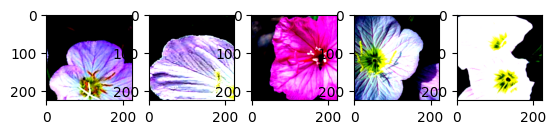

In [ ]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1,5)

for i in range(0, 5):
    ax[i].imshow(train_data_with_aug[i][0].permute(1,2,0))

In [ ]:
models.resnet50(weights=models.ResNet50_Weights.DEFAULT).conv1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [ ]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_classification_acc = -np.inf

    def early_stop(self, validation_acc):
        if validation_acc > self.max_classification_acc:
            self.max_classification_acc = validation_acc
            self.counter = 0
        elif validation_acc < (self.max_classification_acc + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
def train_loop(train_loader, model, loss_fn, optimizer):
    model.train(True)
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in tqdm(train_loader, desc='train', leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criteria(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects / len(train_loader.dataset)

    return epoch_loss, epoch_acc

# Test function
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    running_loss, running_corrects = 0, 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='test', leave=False):
            inputs, labels = inputs.to(device), labels.to(device) # add this line
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            loss = criteria(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(predicted == labels.data)

    test_loss = running_loss / size
    test_correct = running_corrects / size

    return test_loss, test_correct

## Experiment 1: Does doing data augmentation make a difference?

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Freeze the weights of the ResNet layers
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 102)

In [ ]:
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopper = EarlyStopper(patience=8, min_delta=0)

In [ ]:
epochs=100
device = "cuda" if torch.cuda.is_available() else "mps"
print(device)

cuda


#### With Augmentation

In [ ]:
tr_loss, tr_correct = [], []
te_loss, te_correct = [], []
model.to(device)
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
for t in tqdm(range(epochs), desc="epochs"):
    train_loss, train_correct = train_loop(train_aug_loader, model, criteria, optimizer)
    test_loss, test_correct = test_loop(valid_loader, model, criteria)

    tr_loss.append(train_loss), tr_correct.append(train_correct)
    te_loss.append(test_loss), te_correct.append(test_correct)
    print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")

    if test_correct > best_acc:
        best_acc = test_correct
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f'Best Accuracy currently: {best_acc}')

    if early_stopper.early_stop(test_correct.item()):
        print("Done!")
        break

epochs:   0%|          | 0/100 [00:00<?, ?it/s]

train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1: Train_accuracy: 7.84%, Train_loss: 4.466354, Test_accuracy: 38.14%, Test_loss: 3.980816
Best Accuracy currently: 0.3813725709915161


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2: Train_accuracy: 56.18%, Train_loss: 3.579025, Test_accuracy: 61.96%, Test_loss: 3.369751
Best Accuracy currently: 0.6196078658103943


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3: Train_accuracy: 70.88%, Train_loss: 3.005148, Test_accuracy: 66.67%, Test_loss: 2.981299
Best Accuracy currently: 0.6666666865348816


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4: Train_accuracy: 79.80%, Train_loss: 2.481179, Test_accuracy: 72.25%, Test_loss: 2.613779
Best Accuracy currently: 0.7225490808486938


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5: Train_accuracy: 83.73%, Train_loss: 2.082144, Test_accuracy: 74.02%, Test_loss: 2.310866
Best Accuracy currently: 0.7401961088180542


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6: Train_accuracy: 84.61%, Train_loss: 1.844662, Test_accuracy: 75.59%, Test_loss: 2.063111
Best Accuracy currently: 0.7558823823928833


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7: Train_accuracy: 88.53%, Train_loss: 1.607266, Test_accuracy: 77.16%, Test_loss: 1.883505
Best Accuracy currently: 0.7715686559677124


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8: Train_accuracy: 90.39%, Train_loss: 1.367780, Test_accuracy: 77.75%, Test_loss: 1.710237
Best Accuracy currently: 0.7774510383605957


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9: Train_accuracy: 90.88%, Train_loss: 1.207338, Test_accuracy: 78.43%, Test_loss: 1.633590
Best Accuracy currently: 0.7843137979507446


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10: Train_accuracy: 90.29%, Train_loss: 1.159810, Test_accuracy: 79.02%, Test_loss: 1.533405
Best Accuracy currently: 0.7901961207389832


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11: Train_accuracy: 91.47%, Train_loss: 1.018866, Test_accuracy: 79.80%, Test_loss: 1.435982
Best Accuracy currently: 0.7980392575263977


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12: Train_accuracy: 92.75%, Train_loss: 0.899490, Test_accuracy: 79.31%, Test_loss: 1.339478


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13: Train_accuracy: 93.73%, Train_loss: 0.815275, Test_accuracy: 82.06%, Test_loss: 1.259852
Best Accuracy currently: 0.8205882906913757


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14: Train_accuracy: 92.16%, Train_loss: 0.814615, Test_accuracy: 79.80%, Test_loss: 1.277550


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15: Train_accuracy: 93.63%, Train_loss: 0.722926, Test_accuracy: 81.47%, Test_loss: 1.195135


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16: Train_accuracy: 92.84%, Train_loss: 0.731885, Test_accuracy: 81.86%, Test_loss: 1.174296


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17: Train_accuracy: 93.92%, Train_loss: 0.633780, Test_accuracy: 81.86%, Test_loss: 1.125740


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18: Train_accuracy: 93.82%, Train_loss: 0.610299, Test_accuracy: 81.96%, Test_loss: 1.104062


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19: Train_accuracy: 94.41%, Train_loss: 0.591989, Test_accuracy: 82.55%, Test_loss: 1.060991
Best Accuracy currently: 0.8254902362823486


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20: Train_accuracy: 95.20%, Train_loss: 0.539720, Test_accuracy: 82.45%, Test_loss: 1.038656


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21: Train_accuracy: 94.41%, Train_loss: 0.547881, Test_accuracy: 82.25%, Test_loss: 1.006236


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22: Train_accuracy: 94.61%, Train_loss: 0.488602, Test_accuracy: 82.45%, Test_loss: 0.978479


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23: Train_accuracy: 94.71%, Train_loss: 0.466433, Test_accuracy: 83.04%, Test_loss: 0.949654
Best Accuracy currently: 0.8303921818733215


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24: Train_accuracy: 95.78%, Train_loss: 0.439995, Test_accuracy: 83.04%, Test_loss: 0.929162


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25: Train_accuracy: 95.69%, Train_loss: 0.462392, Test_accuracy: 83.92%, Test_loss: 0.899503
Best Accuracy currently: 0.8392157554626465


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 26: Train_accuracy: 96.47%, Train_loss: 0.398735, Test_accuracy: 83.04%, Test_loss: 0.904548


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 27: Train_accuracy: 94.80%, Train_loss: 0.425474, Test_accuracy: 83.33%, Test_loss: 0.896374


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 28: Train_accuracy: 96.18%, Train_loss: 0.366799, Test_accuracy: 84.90%, Test_loss: 0.848954
Best Accuracy currently: 0.8490196466445923


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 29: Train_accuracy: 95.00%, Train_loss: 0.371550, Test_accuracy: 84.31%, Test_loss: 0.857356


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30: Train_accuracy: 95.78%, Train_loss: 0.355913, Test_accuracy: 84.31%, Test_loss: 0.850930


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 31: Train_accuracy: 96.96%, Train_loss: 0.326840, Test_accuracy: 83.82%, Test_loss: 0.825383


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 32: Train_accuracy: 95.39%, Train_loss: 0.349627, Test_accuracy: 84.12%, Test_loss: 0.823951


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 33: Train_accuracy: 94.80%, Train_loss: 0.354347, Test_accuracy: 83.63%, Test_loss: 0.831846


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 34: Train_accuracy: 95.10%, Train_loss: 0.346115, Test_accuracy: 83.14%, Test_loss: 0.816657


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 35: Train_accuracy: 96.08%, Train_loss: 0.303503, Test_accuracy: 84.61%, Test_loss: 0.790930


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 36: Train_accuracy: 95.98%, Train_loss: 0.322367, Test_accuracy: 84.12%, Test_loss: 0.783964
Done!


In [ ]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

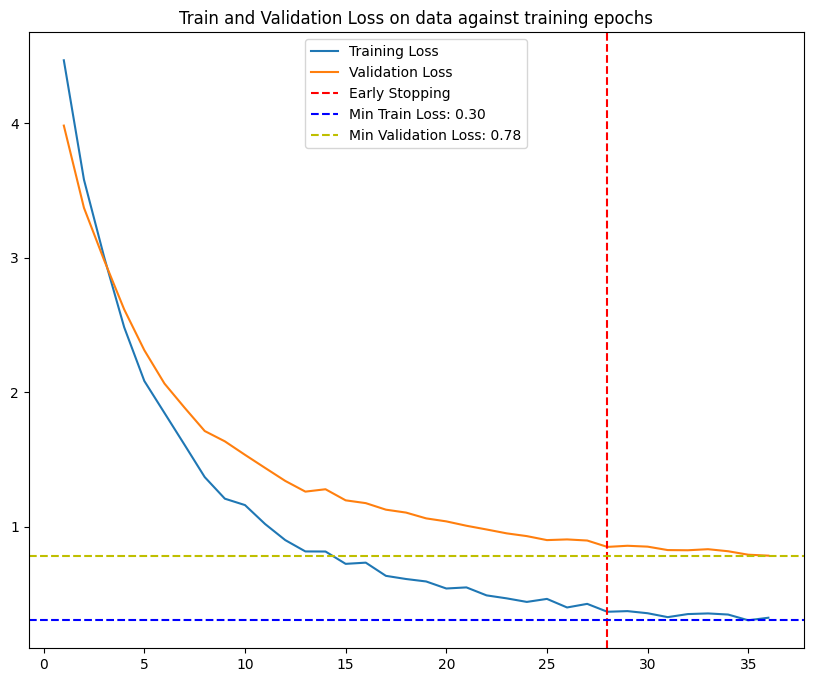

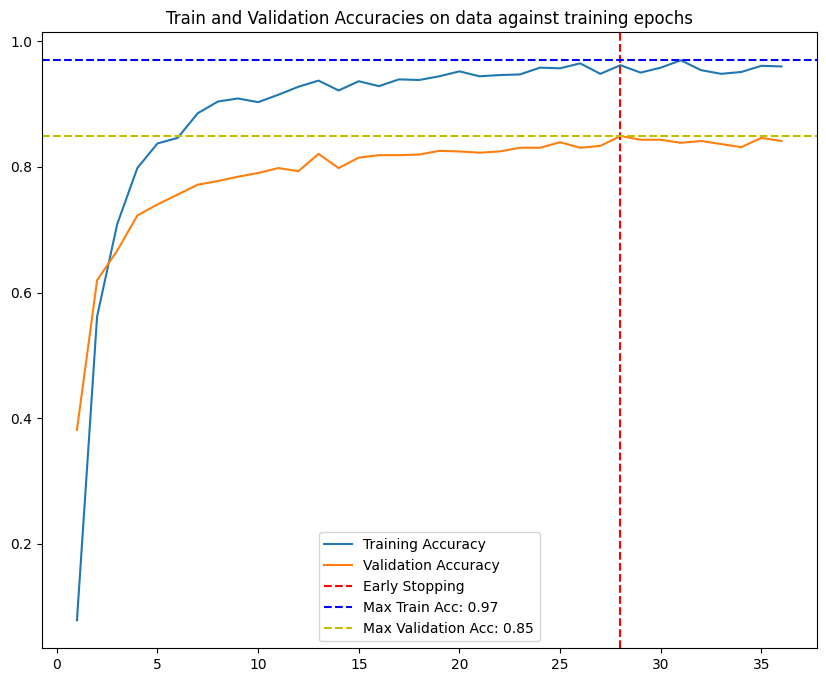

In [ ]:
early_stopping_epoch = len(tr_loss)-8
min_train_loss = min(tr_loss)
min_test_loss = min(te_loss)
max_train_accuracy = max(tr_correct).cpu()
max_test_accuracy = max(te_correct).cpu()
tr_correct1 = [i.cpu() for i in tr_correct]
te_correct1 = [i.cpu() for i in te_correct]

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Loss on data against training epochs')
plt.plot(range(1,len(tr_loss)+1),tr_loss, label='Training Loss')
plt.plot(range(1,len(te_loss)+1),te_loss,label='Validation Loss')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=min_train_loss, color='b', linestyle='--', label=f'Min Train Loss: {min_train_loss:.2f}')
plt.axhline(y=min_test_loss, color='y', linestyle='--', label=f'Min Validation Loss: {min_test_loss:.2f}')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Accuracies on data against training epochs')
plt.plot(range(1,len(tr_correct1)+1),tr_correct1, label='Training Accuracy')
plt.plot(range(1,len(te_correct1)+1),te_correct1, label='Validation Accuracy')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=max_train_accuracy, color='b', linestyle='--', label=f'Max Train Acc: {max_train_accuracy:.2f}')
plt.axhline(y=max_test_accuracy, color='y', linestyle='--', label=f'Max Validation Acc: {max_test_accuracy:.2f}')
plt.legend()
plt.show()

In [ ]:
correct = 0
total = 0
list_predicted = []
list_labels = []
with torch.no_grad():
    for data in tqdm(test_loader, desc='test'):
        images, labels = data
        images, labels = images.to(device), labels.to(device) # add this line
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        predicted, labels = predicted.cpu(), labels.cpu()
        list_predicted.extend(predicted)
        list_labels.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy on test images: ', 100*(correct/total), '%')

aug_f1 = f1_score(list_labels, list_predicted, average='weighted')
aug_acc = 100*(correct/total)

test:   0%|          | 0/193 [00:00<?, ?it/s]

Accuracy on test images:  83.20052040982273 %


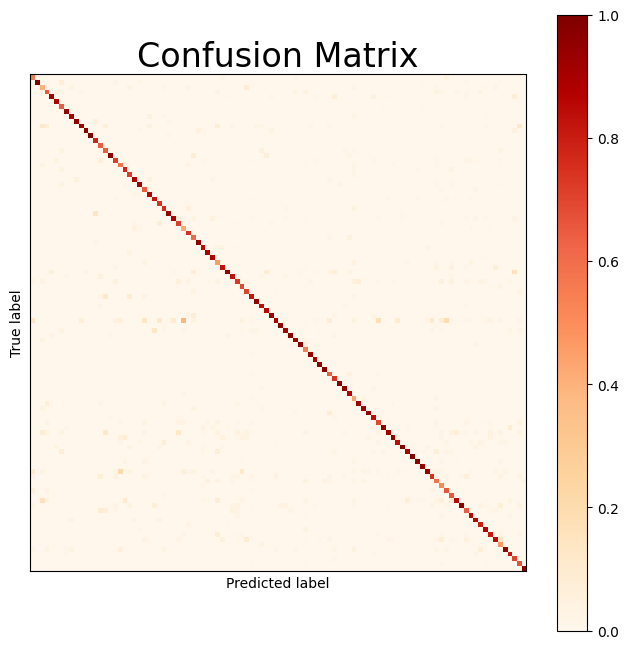

In [ ]:
c_m = confusion_matrix(list_labels, list_predicted, normalize='pred')

plt.rcParams['figure.figsize'] = (8, 8)
display_c_m = ConfusionMatrixDisplay(c_m)
display_c_m.plot(cmap='OrRd', include_values=False)

plt.title('Confusion Matrix', fontsize=24)

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
# Showing the plot
plt.show()

#### Without Augmentation

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Freeze the weights of the ResNet layers
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 102)

In [ ]:
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopper = EarlyStopper(patience=8, min_delta=0)

In [ ]:
tr_loss, tr_correct = [], []
te_loss, te_correct = [], []
model.to(device)
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
for t in tqdm(range(epochs), desc="epochs"):
    train_loss, train_correct = train_loop(train_no_aug_loader, model, criteria, optimizer)
    test_loss, test_correct = test_loop(valid_loader, model, criteria)

    tr_loss.append(train_loss), tr_correct.append(train_correct)
    te_loss.append(test_loss), te_correct.append(test_correct)
    print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")

    if test_correct > best_acc:
        best_acc = test_correct
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f'Best Accuracy currently: {best_acc}')

    if early_stopper.early_stop(test_correct.item()):
        print("Done!")
        break

epochs:   0%|          | 0/100 [00:00<?, ?it/s]

train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1: Train_accuracy: 13.33%, Train_loss: 4.380470, Test_accuracy: 51.57%, Test_loss: 3.826221
Best Accuracy currently: 0.5156863331794739


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2: Train_accuracy: 86.37%, Train_loss: 3.096460, Test_accuracy: 74.12%, Test_loss: 3.127524
Best Accuracy currently: 0.7411764860153198


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3: Train_accuracy: 96.76%, Train_loss: 2.225042, Test_accuracy: 77.45%, Test_loss: 2.601353
Best Accuracy currently: 0.774509847164154


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4: Train_accuracy: 98.82%, Train_loss: 1.554011, Test_accuracy: 79.61%, Test_loss: 2.219100
Best Accuracy currently: 0.7960785031318665


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5: Train_accuracy: 99.12%, Train_loss: 1.129816, Test_accuracy: 80.39%, Test_loss: 1.973832
Best Accuracy currently: 0.803921639919281


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6: Train_accuracy: 99.90%, Train_loss: 0.822125, Test_accuracy: 81.76%, Test_loss: 1.747209
Best Accuracy currently: 0.8176470994949341


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7: Train_accuracy: 99.90%, Train_loss: 0.613479, Test_accuracy: 81.76%, Test_loss: 1.559472


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8: Train_accuracy: 100.00%, Train_loss: 0.480110, Test_accuracy: 82.35%, Test_loss: 1.522289
Best Accuracy currently: 0.8235294818878174


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9: Train_accuracy: 99.90%, Train_loss: 0.398375, Test_accuracy: 83.14%, Test_loss: 1.429267
Best Accuracy currently: 0.8313726186752319


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10: Train_accuracy: 100.00%, Train_loss: 0.301896, Test_accuracy: 82.16%, Test_loss: 1.333808


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11: Train_accuracy: 100.00%, Train_loss: 0.269369, Test_accuracy: 83.53%, Test_loss: 1.282485
Best Accuracy currently: 0.8352941870689392


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12: Train_accuracy: 100.00%, Train_loss: 0.236169, Test_accuracy: 82.65%, Test_loss: 1.235402


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13: Train_accuracy: 100.00%, Train_loss: 0.191060, Test_accuracy: 82.84%, Test_loss: 1.195585


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14: Train_accuracy: 100.00%, Train_loss: 0.168014, Test_accuracy: 83.53%, Test_loss: 1.169475


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15: Train_accuracy: 100.00%, Train_loss: 0.143717, Test_accuracy: 83.33%, Test_loss: 1.130940


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16: Train_accuracy: 100.00%, Train_loss: 0.138245, Test_accuracy: 82.84%, Test_loss: 1.103319


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17: Train_accuracy: 100.00%, Train_loss: 0.128946, Test_accuracy: 83.73%, Test_loss: 1.092214
Best Accuracy currently: 0.8372549414634705


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18: Train_accuracy: 100.00%, Train_loss: 0.111874, Test_accuracy: 84.02%, Test_loss: 1.056148
Best Accuracy currently: 0.8401961326599121


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19: Train_accuracy: 100.00%, Train_loss: 0.097272, Test_accuracy: 84.02%, Test_loss: 1.035013


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20: Train_accuracy: 100.00%, Train_loss: 0.091952, Test_accuracy: 83.63%, Test_loss: 1.033551


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21: Train_accuracy: 100.00%, Train_loss: 0.076888, Test_accuracy: 83.92%, Test_loss: 0.993888


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22: Train_accuracy: 100.00%, Train_loss: 0.072394, Test_accuracy: 83.04%, Test_loss: 0.994808


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23: Train_accuracy: 100.00%, Train_loss: 0.071165, Test_accuracy: 84.02%, Test_loss: 0.962245


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24: Train_accuracy: 100.00%, Train_loss: 0.060439, Test_accuracy: 83.63%, Test_loss: 0.970854


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25: Train_accuracy: 100.00%, Train_loss: 0.058970, Test_accuracy: 83.63%, Test_loss: 0.962064


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 26: Train_accuracy: 100.00%, Train_loss: 0.057486, Test_accuracy: 84.02%, Test_loss: 0.934459


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 27: Train_accuracy: 100.00%, Train_loss: 0.054272, Test_accuracy: 84.31%, Test_loss: 0.935705
Best Accuracy currently: 0.8431373238563538


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 28: Train_accuracy: 100.00%, Train_loss: 0.053747, Test_accuracy: 83.14%, Test_loss: 0.946358


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 29: Train_accuracy: 100.00%, Train_loss: 0.045505, Test_accuracy: 84.51%, Test_loss: 0.889713
Best Accuracy currently: 0.845098078250885


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30: Train_accuracy: 100.00%, Train_loss: 0.040785, Test_accuracy: 84.12%, Test_loss: 0.891193


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 31: Train_accuracy: 100.00%, Train_loss: 0.035243, Test_accuracy: 84.31%, Test_loss: 0.882299


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 32: Train_accuracy: 100.00%, Train_loss: 0.039147, Test_accuracy: 84.12%, Test_loss: 0.884953


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 33: Train_accuracy: 100.00%, Train_loss: 0.040358, Test_accuracy: 83.53%, Test_loss: 0.904464


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 34: Train_accuracy: 100.00%, Train_loss: 0.033016, Test_accuracy: 84.22%, Test_loss: 0.875437


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 35: Train_accuracy: 100.00%, Train_loss: 0.033410, Test_accuracy: 84.41%, Test_loss: 0.869722


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 36: Train_accuracy: 100.00%, Train_loss: 0.031901, Test_accuracy: 84.71%, Test_loss: 0.863567
Best Accuracy currently: 0.847058892250061


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 37: Train_accuracy: 100.00%, Train_loss: 0.028990, Test_accuracy: 84.61%, Test_loss: 0.844900


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 38: Train_accuracy: 100.00%, Train_loss: 0.024826, Test_accuracy: 83.82%, Test_loss: 0.845891


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 39: Train_accuracy: 100.00%, Train_loss: 0.029504, Test_accuracy: 84.12%, Test_loss: 0.851509


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 40: Train_accuracy: 100.00%, Train_loss: 0.029173, Test_accuracy: 84.02%, Test_loss: 0.841994


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 41: Train_accuracy: 100.00%, Train_loss: 0.025026, Test_accuracy: 84.12%, Test_loss: 0.835157


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 42: Train_accuracy: 100.00%, Train_loss: 0.021300, Test_accuracy: 84.22%, Test_loss: 0.811822


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 43: Train_accuracy: 100.00%, Train_loss: 0.023033, Test_accuracy: 84.41%, Test_loss: 0.823489


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 44: Train_accuracy: 100.00%, Train_loss: 0.020698, Test_accuracy: 84.22%, Test_loss: 0.814618
Done!


In [ ]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

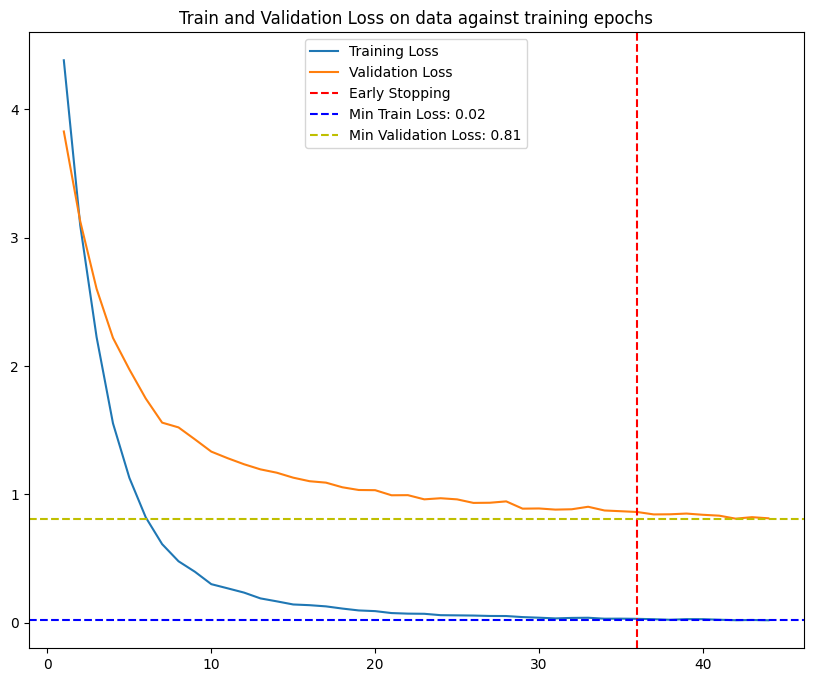

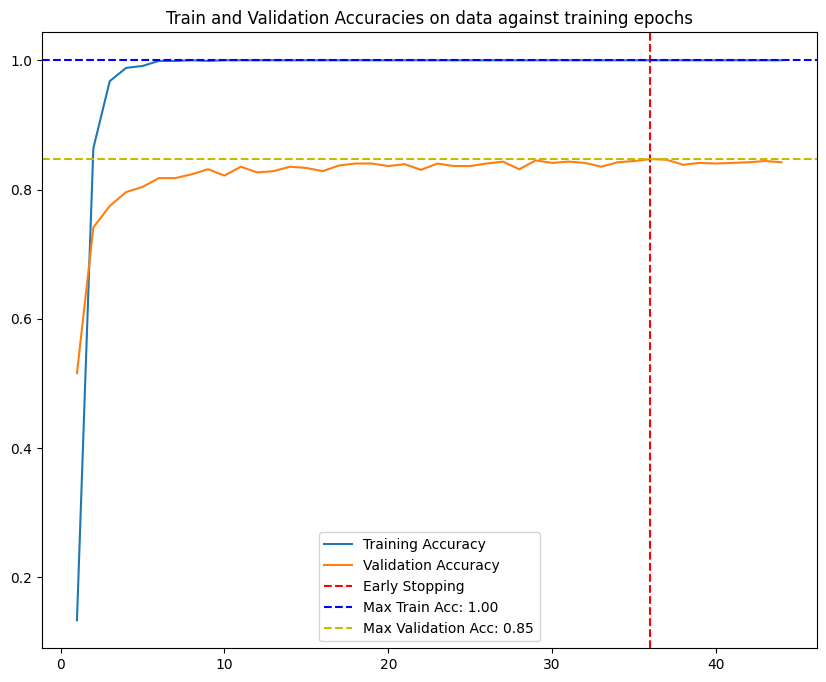

In [ ]:
early_stopping_epoch = len(tr_loss)-8
min_train_loss = min(tr_loss)
min_test_loss = min(te_loss)
max_train_accuracy = max(tr_correct).cpu()
max_test_accuracy = max(te_correct).cpu()
tr_correct1 = [i.cpu() for i in tr_correct]
te_correct1 = [i.cpu() for i in te_correct]

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Loss on data against training epochs')
plt.plot(range(1,len(tr_loss)+1),tr_loss, label='Training Loss')
plt.plot(range(1,len(te_loss)+1),te_loss,label='Validation Loss')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=min_train_loss, color='b', linestyle='--', label=f'Min Train Loss: {min_train_loss:.2f}')
plt.axhline(y=min_test_loss, color='y', linestyle='--', label=f'Min Validation Loss: {min_test_loss:.2f}')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Accuracies on data against training epochs')
plt.plot(range(1,len(tr_correct1)+1),tr_correct1, label='Training Accuracy')
plt.plot(range(1,len(te_correct1)+1),te_correct1, label='Validation Accuracy')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=max_train_accuracy, color='b', linestyle='--', label=f'Max Train Acc: {max_train_accuracy:.2f}')
plt.axhline(y=max_test_accuracy, color='y', linestyle='--', label=f'Max Validation Acc: {max_test_accuracy:.2f}')
plt.legend()
plt.show()

In [ ]:
correct = 0
total = 0
list_predicted = []
list_labels = []
with torch.no_grad():
    for data in tqdm(test_loader, desc='test'):
        images, labels = data
        images, labels = images.to(device), labels.to(device) # add this line
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        predicted, labels = predicted.cpu(), labels.cpu()
        list_predicted.extend(predicted)
        list_labels.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy on test images: ', 100*(correct/total), '%')

no_aug_f1 = f1_score(list_predicted, list_labels, average='weighted')
no_aug_acc = 100*(correct/total)

test:   0%|          | 0/193 [00:00<?, ?it/s]

Accuracy on test images:  82.48495690356155 %


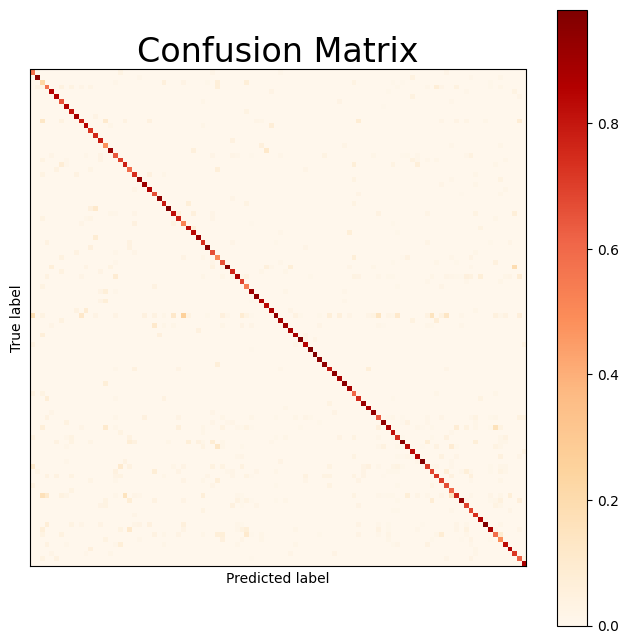

In [ ]:
c_m = confusion_matrix(list_labels, list_predicted, normalize='pred')

plt.rcParams['figure.figsize'] = (8, 8)
display_c_m = ConfusionMatrixDisplay(c_m)
display_c_m.plot(cmap='OrRd', include_values=False)

plt.title('Confusion Matrix', fontsize=24)

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
# Showing the plot
plt.show()

In [ ]:
print(f"""
Accuracy with augmentation: {aug_acc}%
F1 with augmentation {aug_f1}
Accuracy w/o augmentation: {no_aug_acc}%
F1 without augmentation {no_aug_f1}
""")


Accuracy with augmentation: 83.20052040982273%
F1 with augmentation 0.8307868692032684
Accuracy w/o augmentation: 82.48495690356155%
F1 without augmentation 0.8267849130166328



#### Conclusion on Augmentation

Augmentation does help to improve the overall accuracy and to mitigate the model from overfitting.

### Experiment 2: Inclusion of MixUp Augmentation

In [ ]:
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Compute the mixup data. Return mixed inputs, pairs of targets, and lambda
      - https://github.com/hongyi-zhang/mixup
    '''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]

    return mixed_x, y_a, y_b, lam

def mixup_criterion(y_a, y_b, lam):
    '''
    - Mixup criterion
    - https://github.com/hongyi-zhang/mixup
    '''
    return lambda criterion, pred: lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

mixup = True

##### Mixup

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Freeze the weights of the ResNet layers
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 102)

In [ ]:
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopper = EarlyStopper(patience=8, min_delta=0)

In [ ]:
def train_loop_mixup(train_loader, net, optimizer, alpha):
    use_cuda=True
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader, desc='train', leave=False)):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()

        # generate mixed inputs, two one-hot label vectors and mixing coefficient
        inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, alpha, use_cuda)
        inputs, targets_a, targets_b = Variable(inputs), Variable(targets_a), Variable(targets_b)
        outputs = net(inputs)
        loss_func = mixup_criterion(targets_a, targets_b, lam)
        loss = loss_func(criteria, outputs)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += lam * predicted.eq(targets_a.data).cpu().sum() + (1 - lam) * predicted.eq(targets_b.data).cpu().sum()
    return (train_loss/batch_idx, 100.*correct/total)


tr_loss, tr_correct = [], []
te_loss, te_correct = [], []
model.to(device)
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
for t in range(epochs):
    train_loss, train_correct = train_loop_mixup(train_aug_loader, model, optimizer, 0.2)
    test_loss, test_correct = test_loop(valid_loader, model, criteria)

    tr_loss.append(train_loss), tr_correct.append(train_correct)
    te_loss.append(test_loss), te_correct.append(test_correct)
    print(f"Epoch {t+1}: Train_accuracy: {(train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")

    if test_correct > best_acc:
        best_acc = test_correct
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f'Best Accuracy currently: {best_acc}')

    if early_stopper.early_stop(test_correct.item()):
        print("Done!")
        break

train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1: Train_accuracy: 6.55%, Train_loss: 4.638320, Test_accuracy: 44.61%, Test_loss: 4.048331
Best Accuracy currently: 0.44607844948768616


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2: Train_accuracy: 35.54%, Train_loss: 3.983238, Test_accuracy: 59.12%, Test_loss: 3.662119
Best Accuracy currently: 0.5911765098571777


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3: Train_accuracy: 55.82%, Train_loss: 3.461904, Test_accuracy: 63.43%, Test_loss: 3.242443
Best Accuracy currently: 0.6343137621879578


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4: Train_accuracy: 62.60%, Train_loss: 3.104775, Test_accuracy: 66.18%, Test_loss: 2.931822
Best Accuracy currently: 0.6617647409439087


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5: Train_accuracy: 58.29%, Train_loss: 2.963166, Test_accuracy: 66.08%, Test_loss: 2.795439


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6: Train_accuracy: 73.06%, Train_loss: 2.437403, Test_accuracy: 73.43%, Test_loss: 2.442377
Best Accuracy currently: 0.7343137860298157


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7: Train_accuracy: 77.12%, Train_loss: 2.175629, Test_accuracy: 74.41%, Test_loss: 2.287367
Best Accuracy currently: 0.7441176772117615


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8: Train_accuracy: 75.12%, Train_loss: 2.064671, Test_accuracy: 75.00%, Test_loss: 2.147854
Best Accuracy currently: 0.7500000596046448


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9: Train_accuracy: 72.24%, Train_loss: 2.151543, Test_accuracy: 73.63%, Test_loss: 2.163029


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10: Train_accuracy: 73.08%, Train_loss: 2.020399, Test_accuracy: 75.29%, Test_loss: 1.985790
Best Accuracy currently: 0.7529412508010864


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11: Train_accuracy: 72.96%, Train_loss: 1.887909, Test_accuracy: 76.57%, Test_loss: 1.926524
Best Accuracy currently: 0.7656863331794739


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12: Train_accuracy: 80.06%, Train_loss: 1.647294, Test_accuracy: 77.45%, Test_loss: 1.651818
Best Accuracy currently: 0.774509847164154


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13: Train_accuracy: 82.18%, Train_loss: 1.537038, Test_accuracy: 79.12%, Test_loss: 1.602961
Best Accuracy currently: 0.7911764979362488


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14: Train_accuracy: 76.32%, Train_loss: 1.649324, Test_accuracy: 77.16%, Test_loss: 1.718360


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15: Train_accuracy: 71.86%, Train_loss: 1.841541, Test_accuracy: 77.75%, Test_loss: 1.656257


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16: Train_accuracy: 85.06%, Train_loss: 1.292012, Test_accuracy: 79.90%, Test_loss: 1.531689
Best Accuracy currently: 0.7990196347236633


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17: Train_accuracy: 84.49%, Train_loss: 1.274234, Test_accuracy: 81.57%, Test_loss: 1.391506
Best Accuracy currently: 0.8156863451004028


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18: Train_accuracy: 78.87%, Train_loss: 1.492793, Test_accuracy: 77.45%, Test_loss: 1.490271


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19: Train_accuracy: 76.82%, Train_loss: 1.545691, Test_accuracy: 79.80%, Test_loss: 1.488074


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20: Train_accuracy: 80.84%, Train_loss: 1.359589, Test_accuracy: 81.57%, Test_loss: 1.331369


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21: Train_accuracy: 74.78%, Train_loss: 1.584179, Test_accuracy: 80.69%, Test_loss: 1.479558


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22: Train_accuracy: 87.59%, Train_loss: 1.014398, Test_accuracy: 82.45%, Test_loss: 1.227314
Best Accuracy currently: 0.824509859085083


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23: Train_accuracy: 80.84%, Train_loss: 1.221806, Test_accuracy: 83.24%, Test_loss: 1.266650
Best Accuracy currently: 0.8323529958724976


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24: Train_accuracy: 84.61%, Train_loss: 1.129124, Test_accuracy: 81.96%, Test_loss: 1.288018


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25: Train_accuracy: 83.57%, Train_loss: 1.134612, Test_accuracy: 83.53%, Test_loss: 1.235681
Best Accuracy currently: 0.8352941870689392


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 26: Train_accuracy: 82.62%, Train_loss: 1.209697, Test_accuracy: 81.76%, Test_loss: 1.259875


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 27: Train_accuracy: 82.91%, Train_loss: 1.179956, Test_accuracy: 84.61%, Test_loss: 1.148609
Best Accuracy currently: 0.8460784554481506


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 28: Train_accuracy: 87.77%, Train_loss: 0.971211, Test_accuracy: 83.24%, Test_loss: 1.061769


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 29: Train_accuracy: 81.85%, Train_loss: 1.223587, Test_accuracy: 83.63%, Test_loss: 1.116463


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30: Train_accuracy: 85.03%, Train_loss: 1.031171, Test_accuracy: 83.43%, Test_loss: 1.147310


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 31: Train_accuracy: 83.11%, Train_loss: 1.070532, Test_accuracy: 83.63%, Test_loss: 1.094335


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 32: Train_accuracy: 79.06%, Train_loss: 1.324333, Test_accuracy: 81.57%, Test_loss: 1.266847


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 33: Train_accuracy: 88.71%, Train_loss: 0.932162, Test_accuracy: 83.14%, Test_loss: 1.008109


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 34: Train_accuracy: 85.14%, Train_loss: 1.052361, Test_accuracy: 84.41%, Test_loss: 1.126542


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 35: Train_accuracy: 84.76%, Train_loss: 1.043373, Test_accuracy: 84.22%, Test_loss: 1.006700
Done!


In [ ]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

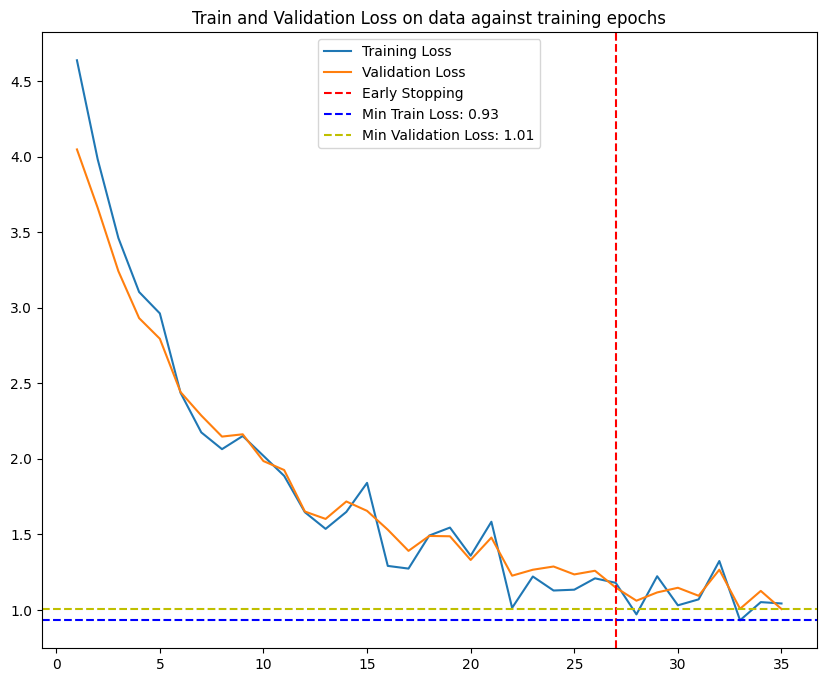

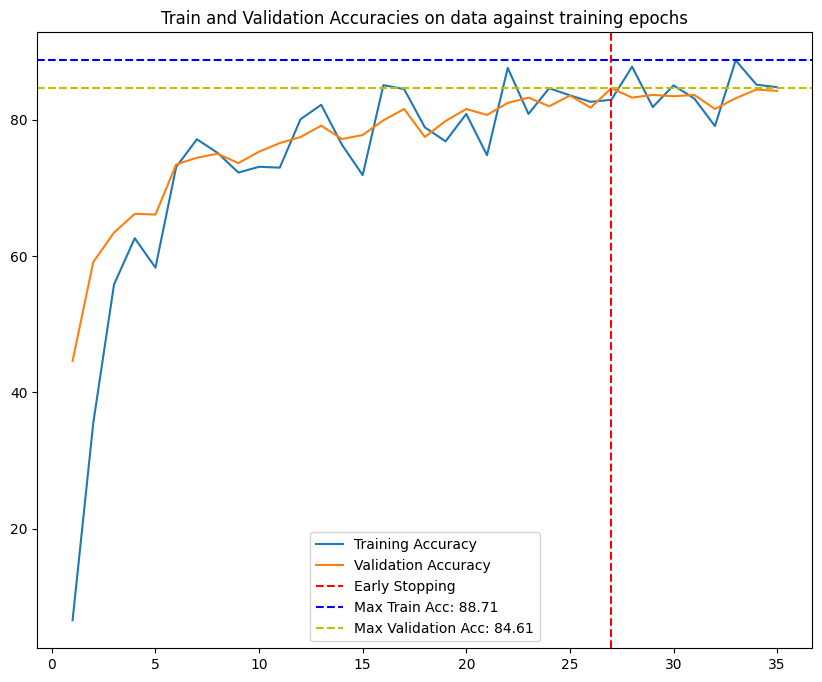

In [ ]:
early_stopping_epoch = len(tr_loss)-8
min_train_loss = min(tr_loss)
min_test_loss = min(te_loss)
max_train_accuracy = max(tr_correct).cpu()
tr_correct1 = [i.cpu() for i in tr_correct]
te_correct1 = [i.cpu()*100 for i in te_correct]
max_test_accuracy = max(te_correct1).cpu()

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Loss on data against training epochs')
plt.plot(range(1,len(tr_loss)+1),tr_loss, label='Training Loss')
plt.plot(range(1,len(te_loss)+1),te_loss,label='Validation Loss')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=min_train_loss, color='b', linestyle='--', label=f'Min Train Loss: {min_train_loss:.2f}')
plt.axhline(y=min_test_loss, color='y', linestyle='--', label=f'Min Validation Loss: {min_test_loss:.2f}')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Accuracies on data against training epochs')
plt.plot(range(1,len(tr_correct1)+1),tr_correct1, label='Training Accuracy')
plt.plot(range(1,len(te_correct1)+1),te_correct1, label='Validation Accuracy')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=max_train_accuracy, color='b', linestyle='--', label=f'Max Train Acc: {max_train_accuracy:.2f}')
plt.axhline(y=max_test_accuracy, color='y', linestyle='--', label=f'Max Validation Acc: {max_test_accuracy:.2f}')
plt.legend()
plt.show()

In [ ]:
correct = 0
total = 0
list_predicted = []
list_labels = []
with torch.no_grad():
    for data in tqdm(test_loader, desc='test'):
        images, labels = data
        images, labels = images.to(device), labels.to(device) # add this line
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        predicted, labels = predicted.cpu(), labels.cpu()
        list_predicted.extend(predicted)
        list_labels.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy on test images: ', 100*(correct/total), '%')

acc_mix_up_and_aug = 100*(correct/total)
mixup_aug_f1 = f1_score(list_predicted, list_labels, average='weighted')

test:   0%|          | 0/193 [00:00<?, ?it/s]

Accuracy on test images:  81.78565620426086 %


In [ ]:
c_m = confusion_matrix(list_labels, list_predicted, normalize='pred')

# Showing Confusion Matrix in form of 2D Numpy array
print(c_m)

[[0.65384615 0.         0.         ... 0.         0.         0.        ]
 [0.         0.97142857 0.         ... 0.         0.         0.02941176]
 [0.         0.         0.26666667 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.52727273 0.         0.        ]
 [0.         0.         0.         ... 0.         0.68888889 0.02941176]
 [0.         0.         0.         ... 0.         0.         0.82352941]]


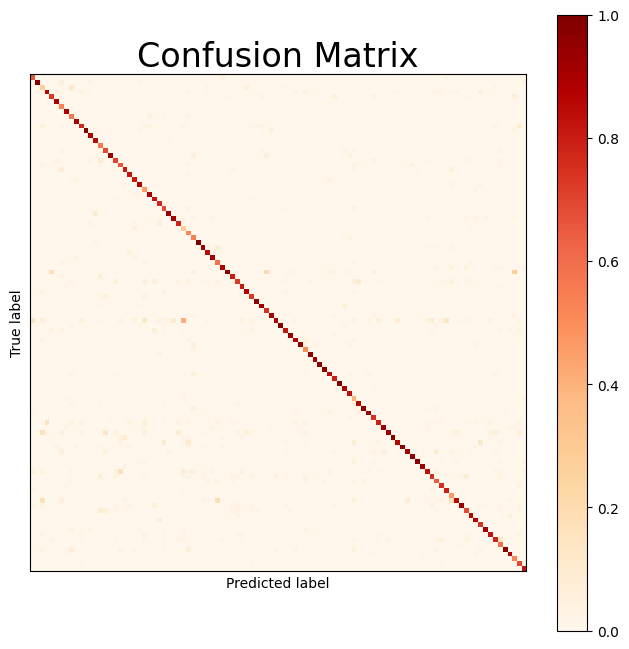

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)
display_c_m = ConfusionMatrixDisplay(c_m)
display_c_m.plot(cmap='OrRd', include_values=False)

plt.title('Confusion Matrix', fontsize=24)

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
# Showing the plot
plt.show()

In [ ]:
print(f"""
Accuracy with augmentation Only: {aug_acc}%
F1 with augmentation Only: {aug_f1}
Accuracy with augmentation and mixup: {acc_mix_up_and_aug}%
F1 with augmentation and mixup {mixup_aug_f1}
""")


Accuracy with augmentation Only: 83.20052040982273%
F1 with augmentation Only: 0.8307868692032684
Accuracy with augmentation and mixup: 82.48495690356155%
F1 with augmentation and mixup 0.81813092459981



#### Conclusion for mixup

So we can observe that helping mixup together with our augmentation helps the model generalise even better and improve our val acc.


### Experiement 3: How does complexity of classification layer affect

#### Complex Layer

Since resnet default classification layer is already very simple

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Freeze the weights of the ResNet layers
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
                nn.Dropout(0.2),
                nn.Linear(2048, 1024),      # Add a fully connected layer
                nn.ReLU(),                     # Add ReLU activation
                nn.Dropout(0.2),               # Add dropout for regularization
                nn.Linear(1024, 102)    # Final output layer for classification
            )

In [ ]:
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopper = EarlyStopper(patience=8, min_delta=0)

In [ ]:

tr_loss, tr_correct = [], []
te_loss, te_correct = [], []
model.to(device)
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
for t in range(epochs):
    train_loss, train_correct = train_loop(train_aug_loader, model, criteria, optimizer)
    test_loss, test_correct = test_loop(valid_loader, model, criteria)

    tr_loss.append(train_loss), tr_correct.append(train_correct)
    te_loss.append(test_loss), te_correct.append(test_correct)
    print(f"Epoch {t+1}: Train_accuracy: {(train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")

    if test_correct > best_acc:
        best_acc = test_correct
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f'Best Accuracy currently: {best_acc}')

    if early_stopper.early_stop(test_correct.item()):
        print("Done!")
        break

train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1: Train_accuracy: 0.10%, Train_loss: 4.502795, Test_accuracy: 37.94%, Test_loss: 4.044849
Best Accuracy currently: 0.3794117867946625


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2: Train_accuracy: 0.35%, Train_loss: 3.477574, Test_accuracy: 44.02%, Test_loss: 2.850993
Best Accuracy currently: 0.44019609689712524


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3: Train_accuracy: 0.54%, Train_loss: 2.322980, Test_accuracy: 57.45%, Test_loss: 1.981245
Best Accuracy currently: 0.574509859085083


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4: Train_accuracy: 0.67%, Train_loss: 1.563216, Test_accuracy: 61.76%, Test_loss: 1.589628
Best Accuracy currently: 0.617647111415863


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5: Train_accuracy: 0.70%, Train_loss: 1.294340, Test_accuracy: 70.78%, Test_loss: 1.288040
Best Accuracy currently: 0.7078431844711304


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6: Train_accuracy: 0.77%, Train_loss: 1.029820, Test_accuracy: 74.12%, Test_loss: 1.140920
Best Accuracy currently: 0.7411764860153198


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7: Train_accuracy: 0.80%, Train_loss: 0.861456, Test_accuracy: 76.27%, Test_loss: 1.035978
Best Accuracy currently: 0.7627451419830322


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8: Train_accuracy: 0.85%, Train_loss: 0.695109, Test_accuracy: 77.35%, Test_loss: 0.961331
Best Accuracy currently: 0.7735294699668884


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9: Train_accuracy: 0.85%, Train_loss: 0.645538, Test_accuracy: 77.45%, Test_loss: 0.894781
Best Accuracy currently: 0.774509847164154


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10: Train_accuracy: 0.87%, Train_loss: 0.550915, Test_accuracy: 77.94%, Test_loss: 0.886587
Best Accuracy currently: 0.779411792755127


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11: Train_accuracy: 0.87%, Train_loss: 0.560462, Test_accuracy: 79.31%, Test_loss: 0.828230
Best Accuracy currently: 0.7931373119354248


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12: Train_accuracy: 0.89%, Train_loss: 0.468309, Test_accuracy: 80.00%, Test_loss: 0.777624
Best Accuracy currently: 0.8000000715255737


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13: Train_accuracy: 0.89%, Train_loss: 0.428316, Test_accuracy: 81.08%, Test_loss: 0.742668
Best Accuracy currently: 0.8107843399047852


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14: Train_accuracy: 0.89%, Train_loss: 0.450890, Test_accuracy: 80.78%, Test_loss: 0.776691


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15: Train_accuracy: 0.91%, Train_loss: 0.397815, Test_accuracy: 83.24%, Test_loss: 0.675173
Best Accuracy currently: 0.8323529958724976


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16: Train_accuracy: 0.90%, Train_loss: 0.385154, Test_accuracy: 81.96%, Test_loss: 0.704204


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17: Train_accuracy: 0.91%, Train_loss: 0.389293, Test_accuracy: 80.29%, Test_loss: 0.733697


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18: Train_accuracy: 0.92%, Train_loss: 0.350236, Test_accuracy: 81.47%, Test_loss: 0.683616


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19: Train_accuracy: 0.90%, Train_loss: 0.361467, Test_accuracy: 82.35%, Test_loss: 0.686062


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20: Train_accuracy: 0.89%, Train_loss: 0.354774, Test_accuracy: 84.02%, Test_loss: 0.634209
Best Accuracy currently: 0.8401961326599121


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21: Train_accuracy: 0.92%, Train_loss: 0.334544, Test_accuracy: 84.02%, Test_loss: 0.628731


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22: Train_accuracy: 0.92%, Train_loss: 0.309082, Test_accuracy: 79.71%, Test_loss: 0.762720


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23: Train_accuracy: 0.94%, Train_loss: 0.265604, Test_accuracy: 83.82%, Test_loss: 0.658727


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24: Train_accuracy: 0.92%, Train_loss: 0.310008, Test_accuracy: 83.82%, Test_loss: 0.633833


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25: Train_accuracy: 0.92%, Train_loss: 0.309066, Test_accuracy: 83.63%, Test_loss: 0.614380


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 26: Train_accuracy: 0.93%, Train_loss: 0.269655, Test_accuracy: 81.96%, Test_loss: 0.667220


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 27: Train_accuracy: 0.93%, Train_loss: 0.256346, Test_accuracy: 83.14%, Test_loss: 0.631079


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 28: Train_accuracy: 0.92%, Train_loss: 0.318714, Test_accuracy: 81.37%, Test_loss: 0.692478


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 29: Train_accuracy: 0.94%, Train_loss: 0.257277, Test_accuracy: 83.04%, Test_loss: 0.611394
Done!


In [ ]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

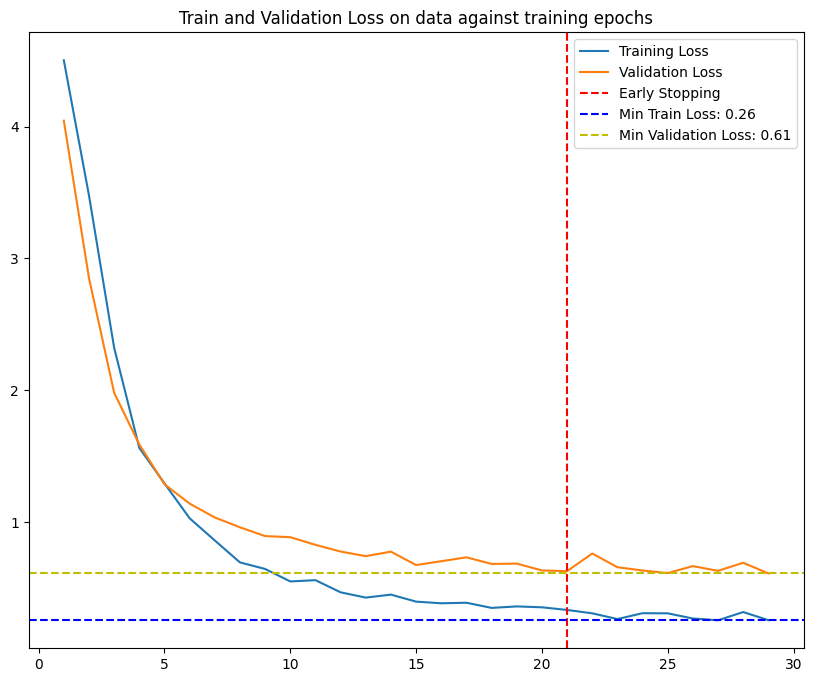

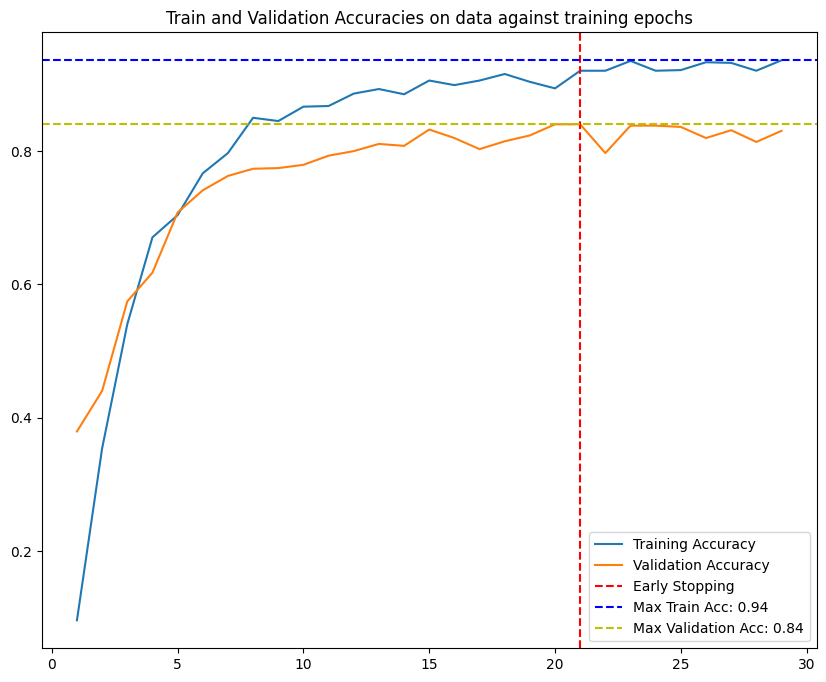

In [ ]:
early_stopping_epoch = len(tr_loss)-8
min_train_loss = min(tr_loss)
min_test_loss = min(te_loss)
max_train_accuracy = max(tr_correct).cpu()
max_test_accuracy = max(te_correct).cpu()
tr_correct1 = [i.cpu() for i in tr_correct]
te_correct1 = [i.cpu() for i in te_correct]

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Loss on data against training epochs')
plt.plot(range(1,len(tr_loss)+1),tr_loss, label='Training Loss')
plt.plot(range(1,len(te_loss)+1),te_loss,label='Validation Loss')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=min_train_loss, color='b', linestyle='--', label=f'Min Train Loss: {min_train_loss:.2f}')
plt.axhline(y=min_test_loss, color='y', linestyle='--', label=f'Min Validation Loss: {min_test_loss:.2f}')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Accuracies on data against training epochs')
plt.plot(range(1,len(tr_correct1)+1),tr_correct1, label='Training Accuracy')
plt.plot(range(1,len(te_correct1)+1),te_correct1, label='Validation Accuracy')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=max_train_accuracy, color='b', linestyle='--', label=f'Max Train Acc: {max_train_accuracy:.2f}')
plt.axhline(y=max_test_accuracy, color='y', linestyle='--', label=f'Max Validation Acc: {max_test_accuracy:.2f}')
plt.legend()
plt.show()

In [ ]:
correct = 0
total = 0
list_predicted = []
list_labels = []
with torch.no_grad():
    for data in tqdm(test_loader, desc='test'):
        images, labels = data
        images, labels = images.to(device), labels.to(device) # add this line
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        predicted, labels = predicted.cpu(), labels.cpu()
        list_predicted.extend(predicted)
        list_labels.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy on test images: ', 100*(correct/total), '%')

complex_acc = 100*(correct/total)
complex_f1 = f1_score(list_predicted, list_labels, average='weighted')

test:   0%|          | 0/193 [00:00<?, ?it/s]

Accuracy on test images:  80.12684989429175 %


In [ ]:
c_m = confusion_matrix(list_labels, list_predicted, normalize='pred')

# Showing Confusion Matrix in form of 2D Numpy array
print(c_m)

[[0.72222222 0.         0.         ... 0.         0.         0.        ]
 [0.         0.97058824 0.         ... 0.         0.         0.        ]
 [0.         0.         0.5        ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.7027027  0.         0.        ]
 [0.         0.         0.         ... 0.         0.96428571 0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


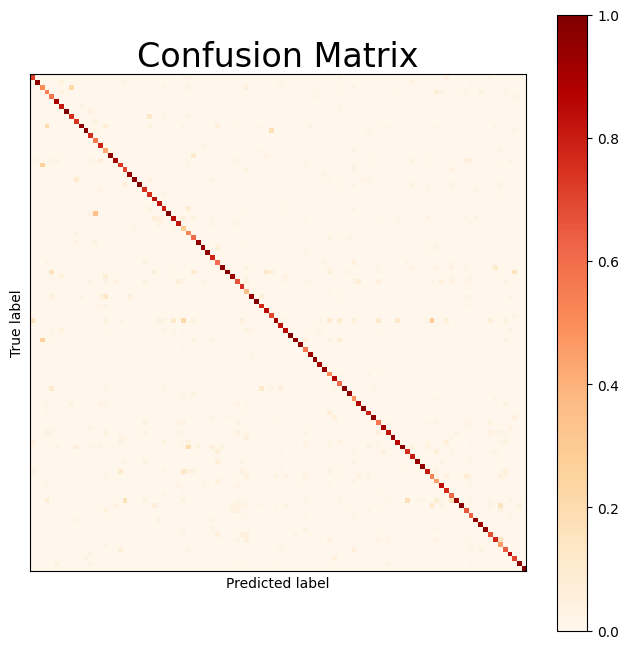

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)
display_c_m = ConfusionMatrixDisplay(c_m)
display_c_m.plot(cmap='OrRd', include_values=False)

plt.title('Confusion Matrix', fontsize=24)

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
# Showing the plot
plt.show()

In [ ]:
print(f"""
Accuracy with augmentation Only: {aug_acc}%
F1 with augmentation Only: {aug_f1}
Accuracy with augmentation Complex Classification Layer: {complex_acc}%
F1 with augmentation Complex Classification Layer {complex_f1}
""")


Accuracy with augmentation Only: 83.20052040982273%
F1 with augmentation Only: 0.8307868692032684
Accuracy with augmentation Complex Classification Layer: 80.12684989429175%
F1 with augmentation Complex Classification Layer 0.8003963675234804



#### Conclusion for Resnet50

Data augmentation + Default Layers to not overfit.

Having a simple classifier i.e one linear layer after convolution, is better for this dataset as the model will not overfit

### Fine Tuning resnet50

To fine tune mobilenet to get the best model, we will first train a mobilenet model with data augmentation and mixup inputs.

Next we will unfreeze all classification layers + the last inverted residual layer and set learning rate to be 0.0001 using Adam Optimizer

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Freeze the weights of the ResNet layers
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
                nn.Linear(2048, 102),      # Add a fully connected layer
            )

In [ ]:
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopper = EarlyStopper(patience=8, min_delta=0)

In [ ]:
tr_loss, tr_correct = [], []
te_loss, te_correct = [], []
model.to(device)
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
for t in range(epochs):
    train_loss, train_correct = train_loop(train_aug_loader, model, criteria, optimizer)
    test_loss, test_correct = test_loop(valid_loader, model, criteria)

    tr_loss.append(train_loss), tr_correct.append(train_correct)
    te_loss.append(test_loss), te_correct.append(test_correct)
    print(f"Epoch {t+1}: Train_accuracy: {(train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")

    if test_correct > best_acc:
        best_acc = test_correct
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f'Best Accuracy currently: {best_acc}')

    if early_stopper.early_stop(test_correct.item()):
        print("Done!")
        break

train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1: Train_accuracy: 0.07%, Train_loss: 4.479681, Test_accuracy: 42.65%, Test_loss: 3.990399
Best Accuracy currently: 0.4264706075191498


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2: Train_accuracy: 0.56%, Train_loss: 3.611552, Test_accuracy: 61.76%, Test_loss: 3.391590
Best Accuracy currently: 0.617647111415863


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3: Train_accuracy: 0.74%, Train_loss: 2.953291, Test_accuracy: 68.24%, Test_loss: 2.936038
Best Accuracy currently: 0.6823529601097107


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4: Train_accuracy: 0.79%, Train_loss: 2.499754, Test_accuracy: 70.29%, Test_loss: 2.602012
Best Accuracy currently: 0.7029412388801575


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5: Train_accuracy: 0.84%, Train_loss: 2.068494, Test_accuracy: 72.75%, Test_loss: 2.321292
Best Accuracy currently: 0.7274510264396667


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6: Train_accuracy: 0.85%, Train_loss: 1.786158, Test_accuracy: 74.80%, Test_loss: 2.110919
Best Accuracy currently: 0.7480392456054688


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7: Train_accuracy: 0.87%, Train_loss: 1.557884, Test_accuracy: 76.08%, Test_loss: 1.863072
Best Accuracy currently: 0.760784387588501


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8: Train_accuracy: 0.90%, Train_loss: 1.385570, Test_accuracy: 76.76%, Test_loss: 1.765835
Best Accuracy currently: 0.7676470875740051


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9: Train_accuracy: 0.89%, Train_loss: 1.213304, Test_accuracy: 78.04%, Test_loss: 1.595736
Best Accuracy currently: 0.7803922295570374


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10: Train_accuracy: 0.89%, Train_loss: 1.119564, Test_accuracy: 78.92%, Test_loss: 1.516159
Best Accuracy currently: 0.7892157435417175


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11: Train_accuracy: 0.91%, Train_loss: 1.013305, Test_accuracy: 79.31%, Test_loss: 1.421701
Best Accuracy currently: 0.7931373119354248


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12: Train_accuracy: 0.93%, Train_loss: 0.905713, Test_accuracy: 79.61%, Test_loss: 1.372447
Best Accuracy currently: 0.7960785031318665


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13: Train_accuracy: 0.91%, Train_loss: 0.853984, Test_accuracy: 80.49%, Test_loss: 1.305356
Best Accuracy currently: 0.8049020171165466


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14: Train_accuracy: 0.93%, Train_loss: 0.788900, Test_accuracy: 80.39%, Test_loss: 1.271997


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15: Train_accuracy: 0.93%, Train_loss: 0.742302, Test_accuracy: 81.27%, Test_loss: 1.205153
Best Accuracy currently: 0.8127451539039612


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16: Train_accuracy: 0.94%, Train_loss: 0.689474, Test_accuracy: 80.49%, Test_loss: 1.179238


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17: Train_accuracy: 0.94%, Train_loss: 0.659607, Test_accuracy: 81.96%, Test_loss: 1.110793
Best Accuracy currently: 0.8196079134941101


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18: Train_accuracy: 0.95%, Train_loss: 0.613852, Test_accuracy: 82.06%, Test_loss: 1.097659
Best Accuracy currently: 0.8205882906913757


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19: Train_accuracy: 0.95%, Train_loss: 0.566889, Test_accuracy: 81.47%, Test_loss: 1.086377


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20: Train_accuracy: 0.95%, Train_loss: 0.540810, Test_accuracy: 82.65%, Test_loss: 1.018460
Best Accuracy currently: 0.8264706134796143


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21: Train_accuracy: 0.95%, Train_loss: 0.514009, Test_accuracy: 81.86%, Test_loss: 1.021728


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22: Train_accuracy: 0.95%, Train_loss: 0.476241, Test_accuracy: 82.35%, Test_loss: 1.013587


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23: Train_accuracy: 0.96%, Train_loss: 0.428675, Test_accuracy: 82.06%, Test_loss: 0.974910


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24: Train_accuracy: 0.96%, Train_loss: 0.438093, Test_accuracy: 83.53%, Test_loss: 0.937013
Best Accuracy currently: 0.8352941870689392


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25: Train_accuracy: 0.95%, Train_loss: 0.453517, Test_accuracy: 82.75%, Test_loss: 0.931427


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 26: Train_accuracy: 0.94%, Train_loss: 0.437512, Test_accuracy: 83.63%, Test_loss: 0.895910
Best Accuracy currently: 0.8362745642662048


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 27: Train_accuracy: 0.97%, Train_loss: 0.343237, Test_accuracy: 83.14%, Test_loss: 0.903190


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 28: Train_accuracy: 0.96%, Train_loss: 0.372740, Test_accuracy: 83.92%, Test_loss: 0.886417
Best Accuracy currently: 0.8392157554626465


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 29: Train_accuracy: 0.95%, Train_loss: 0.408398, Test_accuracy: 83.33%, Test_loss: 0.860591


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30: Train_accuracy: 0.96%, Train_loss: 0.354755, Test_accuracy: 83.63%, Test_loss: 0.847401


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 31: Train_accuracy: 0.95%, Train_loss: 0.370550, Test_accuracy: 84.22%, Test_loss: 0.816159
Best Accuracy currently: 0.8421568870544434


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 32: Train_accuracy: 0.96%, Train_loss: 0.295291, Test_accuracy: 84.61%, Test_loss: 0.798027
Best Accuracy currently: 0.8460784554481506


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 33: Train_accuracy: 0.96%, Train_loss: 0.337180, Test_accuracy: 84.51%, Test_loss: 0.835885


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 34: Train_accuracy: 0.96%, Train_loss: 0.301598, Test_accuracy: 84.12%, Test_loss: 0.840978


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 35: Train_accuracy: 0.97%, Train_loss: 0.292026, Test_accuracy: 84.22%, Test_loss: 0.813182


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 36: Train_accuracy: 0.96%, Train_loss: 0.322122, Test_accuracy: 83.53%, Test_loss: 0.818278


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 37: Train_accuracy: 0.96%, Train_loss: 0.316145, Test_accuracy: 84.90%, Test_loss: 0.760529
Best Accuracy currently: 0.8490196466445923


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 38: Train_accuracy: 0.97%, Train_loss: 0.276433, Test_accuracy: 84.31%, Test_loss: 0.756325


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 39: Train_accuracy: 0.97%, Train_loss: 0.256780, Test_accuracy: 84.61%, Test_loss: 0.753256


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 40: Train_accuracy: 0.96%, Train_loss: 0.299845, Test_accuracy: 84.22%, Test_loss: 0.746306


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 41: Train_accuracy: 0.97%, Train_loss: 0.240583, Test_accuracy: 84.22%, Test_loss: 0.719472


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 42: Train_accuracy: 0.97%, Train_loss: 0.238984, Test_accuracy: 84.41%, Test_loss: 0.745859


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 43: Train_accuracy: 0.97%, Train_loss: 0.251750, Test_accuracy: 84.22%, Test_loss: 0.745061


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 44: Train_accuracy: 0.97%, Train_loss: 0.256992, Test_accuracy: 84.51%, Test_loss: 0.725015


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 45: Train_accuracy: 0.97%, Train_loss: 0.231075, Test_accuracy: 84.22%, Test_loss: 0.706747
Done!


In [ ]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

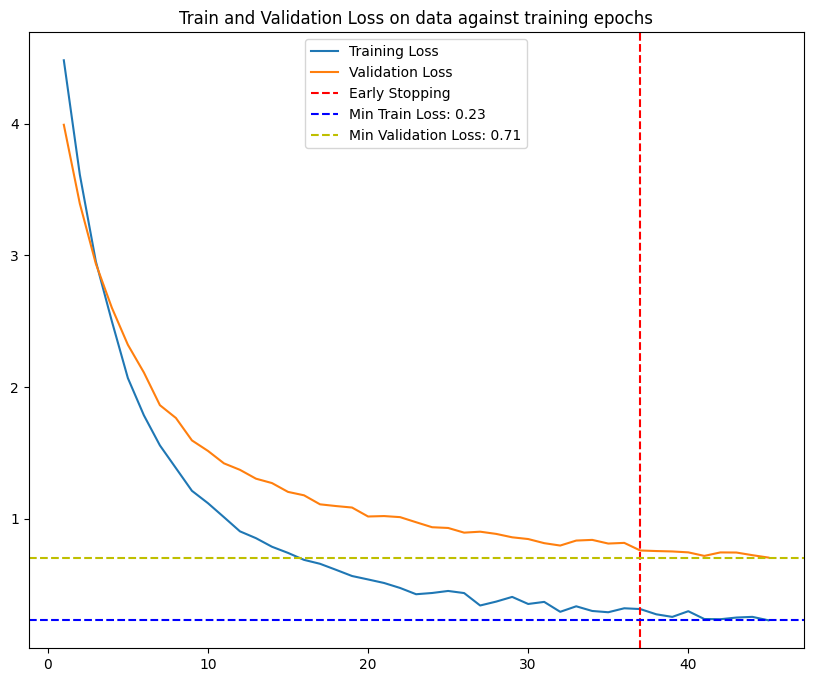

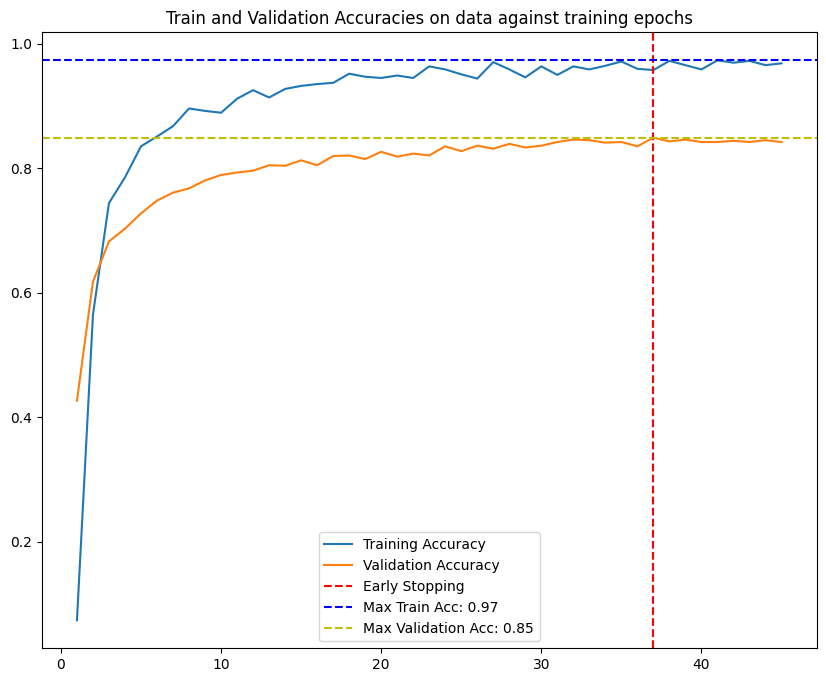

In [ ]:
early_stopping_epoch = len(tr_loss)-8
min_train_loss = min(tr_loss)
min_test_loss = min(te_loss)
max_train_accuracy = max(tr_correct).cpu()
max_test_accuracy = max(te_correct).cpu()
tr_correct1 = [i.cpu() for i in tr_correct]
te_correct1 = [i.cpu() for i in te_correct]

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Loss on data against training epochs')
plt.plot(range(1,len(tr_loss)+1),tr_loss, label='Training Loss')
plt.plot(range(1,len(te_loss)+1),te_loss,label='Validation Loss')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=min_train_loss, color='b', linestyle='--', label=f'Min Train Loss: {min_train_loss:.2f}')
plt.axhline(y=min_test_loss, color='y', linestyle='--', label=f'Min Validation Loss: {min_test_loss:.2f}')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Accuracies on data against training epochs')
plt.plot(range(1,len(tr_correct1)+1),tr_correct1, label='Training Accuracy')
plt.plot(range(1,len(te_correct1)+1),te_correct1, label='Validation Accuracy')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=max_train_accuracy, color='b', linestyle='--', label=f'Max Train Acc: {max_train_accuracy:.2f}')
plt.axhline(y=max_test_accuracy, color='y', linestyle='--', label=f'Max Validation Acc: {max_test_accuracy:.2f}')
plt.legend()
plt.show()

In [ ]:
# Unfreeze last Layer
for param in model.layer4.parameters():
    param.requires_grad = True

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
early_stopper = EarlyStopper(patience=8, min_delta=0)
epochs=30

In [ ]:
tr_loss, tr_correct = [], []
te_loss, te_correct = [], []
model.to(device)
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
for t in range(epochs):
    train_loss, train_correct = train_loop(train_aug_loader, model, criteria, optimizer)
    test_loss, test_correct = test_loop(valid_loader, model, criteria)

    tr_loss.append(train_loss), tr_correct.append(train_correct)
    te_loss.append(test_loss), te_correct.append(test_correct)
    print(f"Epoch {t+1}: Train_accuracy: {(train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")

    if test_correct > best_acc:
        best_acc = test_correct
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f'Best Accuracy currently: {best_acc}')

    if early_stopper.early_stop(test_correct.item()):
        print("Done!")
        break

train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1: Train_accuracy: 0.96%, Train_loss: 0.196784, Test_accuracy: 84.80%, Test_loss: 0.552754
Best Accuracy currently: 0.8480392694473267


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2: Train_accuracy: 0.96%, Train_loss: 0.163927, Test_accuracy: 85.49%, Test_loss: 0.540012
Best Accuracy currently: 0.8549020290374756


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3: Train_accuracy: 0.97%, Train_loss: 0.125159, Test_accuracy: 85.78%, Test_loss: 0.529610
Best Accuracy currently: 0.8578431606292725


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4: Train_accuracy: 0.97%, Train_loss: 0.151653, Test_accuracy: 86.18%, Test_loss: 0.531400
Best Accuracy currently: 0.8617647290229797


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5: Train_accuracy: 0.96%, Train_loss: 0.125011, Test_accuracy: 85.69%, Test_loss: 0.510737


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6: Train_accuracy: 0.98%, Train_loss: 0.111022, Test_accuracy: 87.65%, Test_loss: 0.481540
Best Accuracy currently: 0.8764706254005432


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7: Train_accuracy: 0.98%, Train_loss: 0.107519, Test_accuracy: 87.25%, Test_loss: 0.500304


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8: Train_accuracy: 0.98%, Train_loss: 0.102422, Test_accuracy: 86.86%, Test_loss: 0.493640


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9: Train_accuracy: 0.98%, Train_loss: 0.091180, Test_accuracy: 87.16%, Test_loss: 0.487117


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10: Train_accuracy: 0.98%, Train_loss: 0.107845, Test_accuracy: 87.84%, Test_loss: 0.467595
Best Accuracy currently: 0.8784314393997192


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11: Train_accuracy: 0.98%, Train_loss: 0.093064, Test_accuracy: 88.33%, Test_loss: 0.457750
Best Accuracy currently: 0.8833333849906921


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12: Train_accuracy: 0.98%, Train_loss: 0.071525, Test_accuracy: 88.24%, Test_loss: 0.454425


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13: Train_accuracy: 0.99%, Train_loss: 0.063753, Test_accuracy: 87.84%, Test_loss: 0.453011


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14: Train_accuracy: 0.97%, Train_loss: 0.098732, Test_accuracy: 88.04%, Test_loss: 0.462535


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15: Train_accuracy: 0.98%, Train_loss: 0.067401, Test_accuracy: 88.43%, Test_loss: 0.470395
Best Accuracy currently: 0.8843137621879578


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16: Train_accuracy: 0.98%, Train_loss: 0.079226, Test_accuracy: 88.24%, Test_loss: 0.450311


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17: Train_accuracy: 0.98%, Train_loss: 0.075613, Test_accuracy: 88.82%, Test_loss: 0.442836
Best Accuracy currently: 0.888235330581665


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18: Train_accuracy: 0.99%, Train_loss: 0.064304, Test_accuracy: 89.31%, Test_loss: 0.442175
Best Accuracy currently: 0.8931373357772827


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19: Train_accuracy: 0.98%, Train_loss: 0.079268, Test_accuracy: 88.24%, Test_loss: 0.450827


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20: Train_accuracy: 0.99%, Train_loss: 0.055399, Test_accuracy: 88.73%, Test_loss: 0.441594


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21: Train_accuracy: 0.98%, Train_loss: 0.083013, Test_accuracy: 88.04%, Test_loss: 0.437880


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22: Train_accuracy: 0.98%, Train_loss: 0.077297, Test_accuracy: 88.82%, Test_loss: 0.418441


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23: Train_accuracy: 0.98%, Train_loss: 0.070795, Test_accuracy: 89.61%, Test_loss: 0.401746
Best Accuracy currently: 0.8960784673690796


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24: Train_accuracy: 0.98%, Train_loss: 0.065410, Test_accuracy: 89.31%, Test_loss: 0.396371


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25: Train_accuracy: 0.99%, Train_loss: 0.065666, Test_accuracy: 89.90%, Test_loss: 0.394536
Best Accuracy currently: 0.8990196585655212


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 26: Train_accuracy: 0.99%, Train_loss: 0.065646, Test_accuracy: 89.31%, Test_loss: 0.396989


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 27: Train_accuracy: 0.98%, Train_loss: 0.056603, Test_accuracy: 89.31%, Test_loss: 0.388379


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 28: Train_accuracy: 0.99%, Train_loss: 0.059171, Test_accuracy: 90.00%, Test_loss: 0.389121
Best Accuracy currently: 0.9000000357627869


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 29: Train_accuracy: 0.98%, Train_loss: 0.059754, Test_accuracy: 89.31%, Test_loss: 0.389562


train:   0%|          | 0/32 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30: Train_accuracy: 0.98%, Train_loss: 0.072534, Test_accuracy: 89.71%, Test_loss: 0.393235


In [ ]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

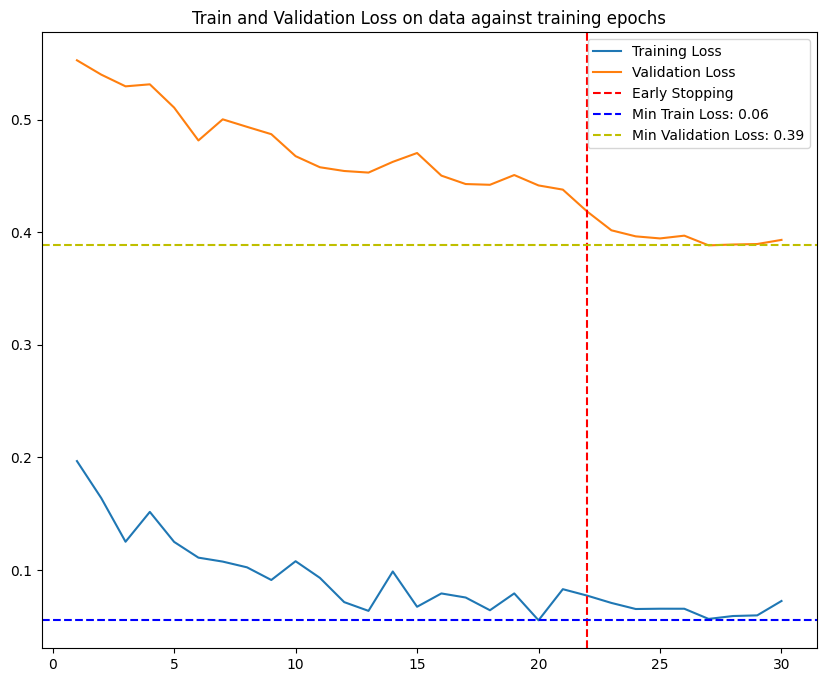

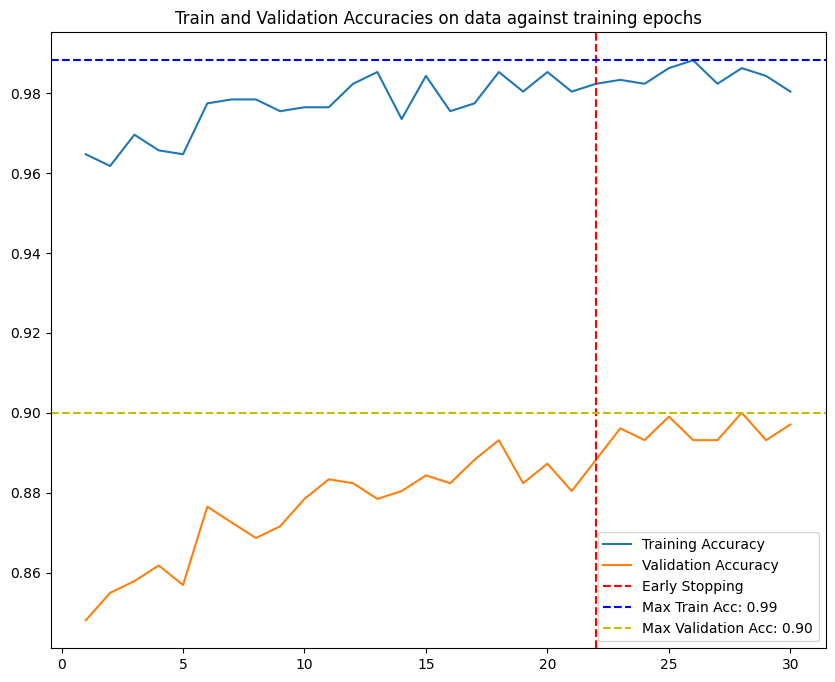

In [ ]:
early_stopping_epoch = len(tr_loss)-8
min_train_loss = min(tr_loss)
min_test_loss = min(te_loss)
max_train_accuracy = max(tr_correct).cpu()
max_test_accuracy = max(te_correct).cpu()
tr_correct1 = [i.cpu() for i in tr_correct]
te_correct1 = [i.cpu() for i in te_correct]

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Loss on data against training epochs')
plt.plot(range(1,len(tr_loss)+1),tr_loss, label='Training Loss')
plt.plot(range(1,len(te_loss)+1),te_loss,label='Validation Loss')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=min_train_loss, color='b', linestyle='--', label=f'Min Train Loss: {min_train_loss:.2f}')
plt.axhline(y=min_test_loss, color='y', linestyle='--', label=f'Min Validation Loss: {min_test_loss:.2f}')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,8))
plt.title('Train and Validation Accuracies on data against training epochs')
plt.plot(range(1,len(tr_correct1)+1),tr_correct1, label='Training Accuracy')
plt.plot(range(1,len(te_correct1)+1),te_correct1, label='Validation Accuracy')
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.axhline(y=max_train_accuracy, color='b', linestyle='--', label=f'Max Train Acc: {max_train_accuracy:.2f}')
plt.axhline(y=max_test_accuracy, color='y', linestyle='--', label=f'Max Validation Acc: {max_test_accuracy:.2f}')
plt.legend()
plt.show()

In [ ]:
correct = 0
total = 0
list_predicted = []
list_labels = []
with torch.no_grad():
    for data in tqdm(test_loader, desc='test'):
        images, labels = data
        images, labels = images.to(device), labels.to(device) # add this line
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        predicted, labels = predicted.cpu(), labels.cpu()
        list_predicted.extend(predicted)
        list_labels.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy on test images: ', 100*(correct/total), '%')

test:   0%|          | 0/193 [00:00<?, ?it/s]

Accuracy on test images:  88.43714425109775 %


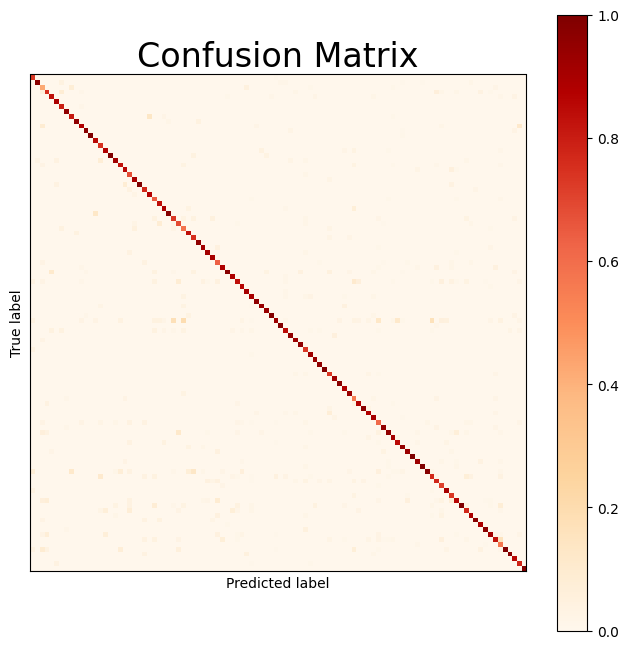

In [ ]:
c_m = confusion_matrix(list_labels, list_predicted, normalize='pred')

plt.rcParams['figure.figsize'] = (8, 8)
display_c_m = ConfusionMatrixDisplay(c_m)
display_c_m.plot(cmap='OrRd', include_values=False)

plt.title('Confusion Matrix', fontsize=24)

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
# Showing the plot
plt.show()

In [ ]:
print(f"F1 Score: {f1_score(list_predicted, list_labels, average='weighted')}")

F1 Score: 0.8851088066755561


In [ ]:
print(classification_report(list_labels, list_predicted))

              precision    recall  f1-score   support

           0       0.73      0.95      0.83        20
           1       0.97      0.85      0.91        40
           2       0.42      0.70      0.53        20
           3       0.75      0.58      0.66        36
           4       0.83      0.87      0.85        45
           5       0.89      1.00      0.94        25
           6       0.79      0.95      0.86        20
           7       0.96      1.00      0.98        65
           8       0.81      0.81      0.81        26
           9       0.96      0.92      0.94        25
          10       0.88      0.85      0.86        67
          11       0.97      0.96      0.96        67
          12       1.00      0.93      0.96        29
          13       0.85      1.00      0.92        28
          14       0.74      1.00      0.85        29
          15       0.88      0.67      0.76        21
          16       1.00      0.97      0.98        65
          17       0.92    